<a href="https://colab.research.google.com/github/romerocruzsa/cp-anemia-detection/blob/notebook-upload/Anemia_MobileNet_BaseVsQAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantized Transfer Learning on MobileNetV2 for Anemia Detection
**Author**: [Sebastián A. Cruz Romero](https://github.com/romerocruzsa/)

**Reviewed by**:

This tutorial builds on [Quantized Transfer Learning for Computer Vision ](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/quantized_transfer_learning_tutorial.ipynb#scrollTo=SFJ7b7dmrVNi) tutorial. Transfer learning refers to methods that leverage pretrained models in different applications and datasets. This tutorial shows how to do quantization-aware training. By the end of this tutorial, you will see how quantization in PyTorch can result in significant decreases in model size while increasing speed. Warning: we use a lot of boilerplate code from other PyTorch repos to, for example, define the [MobileNetV2](https://arxiv.org/abs/1801.04381) model architecture, define data loaders, and so on.

## What is Quantization?

**Quantization refers to techniques for doing both computations and memory accesses with lower precision data**, usually **int8** compared **to floating point** implementations. This enables performance gains in several important areas:

* 4x reduction in model size;
* 2-4x reduction in memory bandwidth;
* 2-4x faster inference due to savings in memory bandwidth and faster compute with int8 arithmetic (the exact speed up varies depending on the hardware, the runtime, and the model).

Quantization does not however come without additional cost. Fundamentally quantization means introducing approximations and the resulting networks have slightly less accuracy. These techniques attempt to minimize the gap between the full floating point accuracy and the quantized accuracy.

## Installing Dependencies and Pre-Requisites

### Installing the PyTorch Nightly Build

Because you will be using the experimental parts of the PyTorch, it is recommended to install the latest version of torch and torchvision. You can find the most recent instructions on local installation here. For example, to install without GPU support:

```shell
pip install numpy
pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
# For CUDA support use https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
```

In [ ]:
!yes y | pip uninstall torch torchvision
!yes y | pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

Found existing installation: torch 2.5.1
Uninstalling torch-2.5.1:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchfrtrace
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.5.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/torch/lib/libcublas.so.12
    /usr/local/lib/python3.10/dist-packages/torch/lib/libcublasLt.so.12
    /usr/local/lib/python3.10/dist-packages/torch/lib/libcudart-9335f6a2.so.12
    /usr/local/lib/python3.10/dist-packages/torch/lib/libcudnn.so.9
    /usr/local/lib/python3.10/dist-packages/torch/lib/libcudnn_adv.so.9
    /usr/local/lib/python3.10/dist-packages/torch/lib/libcudnn_cnn.so.9
    /usr/local/lib/python3.10/dist-packages/torch/lib/libcudnn_

In [ ]:
# Install other dependencies
!yes y | pip install torchinfo
!yes y | pip install torchmetrics

In [ ]:
# Import necessary libraries for file handling, data manipulation, and visualization
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for working with images and transformations
from PIL import Image
import cv2 as cv

# Import PyTorch modules for model building, data handling, and evaluation
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.models.quantization as quant_models
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary

# Import libraries for machine learning metrics and model evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, mean_squared_error, mean_absolute_error, r2_score
import torchmetrics
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Set the seed.
seed = 42
torch.manual_seed(seed)

## CP-AnemiC: A *conjunctival pallor* dataset and benchmark for anemia detection in children

Anemia is a universal public health issue, which occurs as the result of a reduction in red blood cells. Early detection of anemia in children is highly desirable for effective treatment measures. We train and test our quantizable MobileNetV2 architecture to detect anemia on [CP-AnemiC](https://www.sciencedirect.com/science/article/pii/S2590093523000395), comprising 710 individuals (range of age, 6–59 months), gathered from several hospitals in Ghana. The conjunctiva image-based dataset is supported with Hb levels (g/dL) annotations for accurate diagnosis of anemia.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir="/content/drive/MyDrive/CP-AnemiC/"
weights_dir="/content/drive/MyDrive/Weights/"
anemic_dir=data_dir+"/Anemic"
non_anemic_dir=data_dir+"/Non-anemic"

In [ ]:
# data_dir = "/home/sebastian-cruz6/workspace/model-compression/data/cp-anemia/"
# weights_dir = "/home/sebastian-cruz6/workspace/model-compression/models/weights/"
# anemic_dir = data_dir+"Anemic/"
# non_anemic_dir = data_dir+"Non-anemic/"

data_sheet_path = data_dir+"Anemia_Data_Collection_Sheet.csv"
data_sheet = pd.read_csv(data_sheet_path)
display(data_sheet)

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY
0,Image_001,9.80,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana
1,Image_002,9.90,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana
2,Image_003,11.10,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
3,Image_004,12.50,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
4,Image_005,9.90,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana
...,...,...,...,...,...,...,...,...,...,...,...
705,Image_706,12.80,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana
706,Image_707,11.47,Non-Anemic,48,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
707,Image_708,11.60,Non-Anemic,60,Male,Non-anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana
708,Image_709,12.10,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana


In [ ]:
# Mapping diagnosis to severity
severity_mapping = {
    "Non-Anemic": [1,0,0,0],
    "Mild": [0,1,0,0],
    "Moderate": [0,0,1,0],
    "Severe": [0,0,0,1],
}
# Mapping diagnosis to severity
remark_mapping = {
    "Non-anemic": 0,
    "Anemic": 1
}

data_sheet['SEVERITY_ONEHOT'] = data_sheet['Severity'].map(severity_mapping)
data_sheet['REMARK_ONEHOT'] = data_sheet['REMARK'].map(remark_mapping)
display(data_sheet)

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY,SEVERITY_ONEHOT,REMARK_ONEHOT
0,Image_001,9.80,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana,"[0, 0, 1, 0]",1
1,Image_002,9.90,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana,"[0, 0, 1, 0]",1
2,Image_003,11.10,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
3,Image_004,12.50,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
4,Image_005,9.90,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana,"[0, 0, 1, 0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,Image_706,12.80,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]",0
706,Image_707,11.47,Non-Anemic,48,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
707,Image_708,11.60,Non-Anemic,60,Male,Non-anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana,"[1, 0, 0, 0]",0
708,Image_709,12.10,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]",0


### Loading Data

We will use `torchvision` and `torch.utils.data` packages to load the data. The problem we are trying to solve today is classifying images of the inner-part of the eyelid between Anemic and Non-anemic patients. The dataset contains about 710 images of which we will do an 80/20 split between training and testing subset. After that, we perform 5-fold cross-validation with our training set to avoid overfitting on smaller dataset. Since we are using transfer learning, we should be able to generalize reasonably well.

In [ ]:
# # BATCH_SIZE = 4
# # test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# for img, binary_label, multiclass_label, hb_level, descriptor in test_loader:
#   print(binary_label, multiclass_label, hb_level, descriptor)
#   break

In [ ]:
# Define data augmentations or transformations
transform = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.RandomHorizontalFlip(p=np.random.rand()),
    transforms.RandomVerticalFlip(p=np.random.rand()),
    transforms.RandomRotation(degrees=np.random.randint(0, 360)),
    transforms.RandomAffine(degrees=np.random.randint(0, 360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CPAnemiCDataset(Dataset):
    def __init__(self, dir, df, transform=None):
        self.dir = dir
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['IMAGE_ID']
        img_folder = row['REMARK']
        img_path = os.path.join(self.dir, img_folder, img_id + ".png")
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        binary_label = torch.tensor(row['REMARK_ONEHOT'], dtype=torch.float32)  # Adjusted for BCEWithLogitsLoss
        multiclass_label = torch.tensor(row['SEVERITY_ONEHOT'], dtype=torch.float32)
        hb_level = torch.tensor(row['HB_LEVEL'], dtype=torch.float32)
        descriptor = row['REMARK']+"/"+row['Severity']

        return img, binary_label, multiclass_label, hb_level, descriptor

    # Load the dataset
image_dataset = CPAnemiCDataset(data_dir, data_sheet, transform=transform)
train_dataset, test_dataset = train_test_split(image_dataset, test_size=0.20, shuffle=True)

print(f"Image Dataset Size (All): {len(image_dataset)}, \
        Train Size: {len(train_dataset)}, \
        Test Size: {len(test_dataset)}")

BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Image Dataset Size (All): 710,         Train Size: 568,         Test Size: 142


Note that quantization is currently only supported for CPUs, so we will not be utilizing GPUs / CUDA in this tutorial.

In [ ]:
# Default device
device = torch.device('cpu')

# # Check for CUDA availability
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     print("CUDA is not available, using CPU.")

print(f"Selected device: {device}")

Selected device: cpu


## Helper functions

We define several helper functions to help with model evaluation, understanding our predicitve performance, and visualizing our results.

### Performance Metrics and Model Evalution

In [ ]:
# class CumulativeMetrics:
#     def __init__(self):
#         # Initialize torchmetrics for binary classification
#         self.accuracy = torchmetrics.Accuracy(task="binary").to(device)
#         self.precision = torchmetrics.Precision(task="binary", average="macro").to(device)
#         self.recall = torchmetrics.Recall(task="binary", average="macro").to(device)
#         self.f1_score = torchmetrics.F1Score(task="binary", average="macro").to(device)

#         # For scikit-learn metrics, we'll store the true and predicted values for each batch
#         self.y_true_all = []
#         self.y_pred_all = []
#         self.y_score_all = []

#         self.reset()

#     def reset(self):
#         # Reset torchmetrics accumulators
#         self.cum_acc = 0.0
#         self.cum_prec = 0.0
#         self.cum_rec = 0.0
#         self.cum_f1 = 0.0
#         self.num_batches = 0

#         # Reset true and predicted values lists for sklearn
#         self.y_true_all = []
#         self.y_pred_all = []
#         self.y_score_all = []

#     def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
#         # For binary classification, y_true is already a class label (0 or 1)
#         y_pred_class = torch.round(torch.sigmoid(y_pred)).int()  # Get predicted class by rounding sigmoid output

#         # Append predictions and true labels for scikit-learn metrics later
#         self.y_true_all.extend(y_true.cpu().numpy())
#         self.y_pred_all.extend(y_pred_class.cpu().numpy())
#         self.y_score_all.extend(torch.sigmoid(y_pred).detach().cpu().numpy())  # Probabilities/logits for AUC

#         # Update cumulative torchmetrics
#         acc = self.accuracy(y_pred_class, y_true).item()
#         prec = self.precision(y_pred_class, y_true).item()
#         rec = self.recall(y_pred_class, y_true).item()
#         f1 = self.f1_score(y_pred_class, y_true).item()

#         self.cum_acc += acc
#         self.cum_prec += prec
#         self.cum_rec += rec
#         self.cum_f1 += f1
#         self.num_batches += 1

#     def compute(self):
#         avg_acc = self.cum_acc / self.num_batches
#         avg_prec = self.cum_prec / self.num_batches
#         avg_rec = self.cum_rec / self.num_batches
#         avg_f1 = self.cum_f1 / self.num_batches

#         # Ensure y_true_all contains basic data types before using set
#         y_true_list = [int(val) for val in self.y_true_all]

#         # Compute AUC using sklearn
#         if len(self.y_score_all) > 0 and len(set(y_true_list)) > 1:
#             auc = roc_auc_score(self.y_true_all, self.y_score_all)
#         else:
#             auc = None  # If no valid score or only one class present

#         performance_metrics = {
#             "Accuracy": avg_acc,
#             "Precision": avg_prec,
#             "Recall": avg_rec,
#             "F1 Score": avg_f1,
#             "AUC": auc,
#         }
#         return performance_metrics


In [ ]:
import torch
import torchmetrics
import numpy as np
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

class CumulativeMetrics:
    def __init__(self, model_type="binary", num_classes=1, device="cpu"):
        self.model_type = model_type
        self.num_classes = num_classes
        self.device = device
        self.reset()

        # Classification metrics initialization
        if model_type == "binary":
            self.accuracy = torchmetrics.Accuracy(task="binary").to(device)
            self.precision = torchmetrics.Precision(task="binary").to(device)
            self.recall = torchmetrics.Recall(task="binary").to(device)
            self.f1_score = torchmetrics.F1Score(task="binary").to(device)
        elif model_type == "multiclass":
            self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
            self.precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes).to(device)
            self.recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes).to(device)
            self.f1_score = torchmetrics.F1Score(task="multiclass", num_classes=num_classes).to(device)

    def reset(self):
        self.num_batches = 0
        # Cumulative sums for each metric
        self.cum_acc = 0.0
        self.cum_prec = 0.0
        self.cum_rec = 0.0
        self.cum_f1 = 0.0
        self.cum_mse = 0.0
        self.cum_mae = 0.0
        self.cum_r2 = 0.0
        # Storage for AUC
        self.y_true_all = []
        self.y_score_all = []

    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        if self.model_type == "binary":
            y_pred_class = torch.round(torch.sigmoid(y_pred)).int()
            self.y_true_all.extend(y_true.detach().cpu().numpy().tolist())
            self.y_score_all.extend(torch.sigmoid(y_pred).detach().cpu().numpy().tolist())

            # Update binary classification metrics
            self.cum_acc += self.accuracy(y_pred_class, y_true).item()
            self.cum_prec += self.precision(y_pred_class, y_true).item()
            self.cum_rec += self.recall(y_pred_class, y_true).item()
            self.cum_f1 += self.f1_score(y_pred_class, y_true).item()

        elif self.model_type == "multiclass":
            y_pred_class = torch.argmax(y_pred, dim=1)
            y_true_class = torch.argmax(y_true, dim=1)
            self.y_true_all.extend(y_true_class.detach().cpu().numpy().tolist())

            # Update multi-class classification metrics
            self.cum_acc += self.accuracy(y_pred_class, y_true_class).item()
            self.cum_prec += self.precision(y_pred_class, y_true_class).item()
            self.cum_rec += self.recall(y_pred_class, y_true_class).item()
            self.cum_f1 += self.f1_score(y_pred_class, y_true_class).item()

        elif self.model_type == "regression":
            y_true_np = y_true.detach().cpu().numpy()
            y_pred_np = y_pred.detach().cpu().numpy()
            self.y_true_all.extend(y_true_np.tolist())
            self.y_score_all.extend(y_pred_np.tolist())

            # Compute per-batch regression metrics
            self.cum_mse += mean_squared_error(y_true_np, y_pred_np)
            self.cum_mae += mean_absolute_error(y_true_np, y_pred_np)
            self.cum_r2 += r2_score(y_true_np, y_pred_np)

        self.num_batches += 1

    def compute(self):
        if self.model_type in ["binary", "multiclass"]:
            metrics = {
                "Accuracy": self.cum_acc / self.num_batches,
                "Precision": self.cum_prec / self.num_batches,
                "Recall": self.cum_rec / self.num_batches,
                "F1 Score": self.cum_f1 / self.num_batches,
            }
            if self.model_type == "binary":
                try:
                    metrics["AUC"] = roc_auc_score(self.y_true_all, self.y_score_all)
                except ValueError as e:
                    metrics["AUC"] = None
                    print(f"AUC calculation error: {e}")
            return metrics

        elif self.model_type == "regression":
            return {
                "Mean Squared Error": self.cum_mse / self.num_batches,
                "Mean Absolute Error": self.cum_mae / self.num_batches,
                "R2 Score": self.cum_r2 / self.num_batches,
            }

## Model Training and Evaluation

Below is a generic function for model training. This function also

* Calculates model performance metrics (Loss, Accuracy, Precision, F1 Score, etc.)
* Saves the best model per highest F1 Score during the validation fold
* Switches between `Validation` and `Test` phases

In [ ]:
def train(dataloader, model, loss_fn, optimizer, cumulative_metrics, task_type="binary"):
    model.train()
    cumulative_metrics.reset()
    batch_losses = []

    for _, (img, binary, multiclass, hb_level, _) in enumerate(dataloader):
        img = img.to(device)
        binary = binary.to(device).unsqueeze(1).float()
        multiclass = multiclass.to(device)
        hb_level = hb_level.to(device).unsqueeze(1).float()

        optimizer.zero_grad()

        # Forward pass and loss calculation based on task type
        if task_type == "binary":
            pred = model(img)
            loss = loss_fn(pred, binary)  # Binary target
        elif task_type == "multiclass":
            pred = model(img)
            loss = loss_fn(pred, multiclass)  # Multi-class target
        elif task_type == "regression":
            pred = model(img)  # Direct prediction for regression
            loss = loss_fn(pred, hb_level)  # Regression target
        else:
            raise ValueError("Unsupported task type. Choose 'binary', 'multiclass', or 'regression'.")

        # Backpropagation
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        cumulative_metrics.update(pred, binary if task_type == "binary" else multiclass if task_type == "multiclass" else hb_level)

    avg_loss = sum(batch_losses) / len(batch_losses)
    performance_metrics = cumulative_metrics.compute()

    return avg_loss, performance_metrics


def eval(dataloader, model, loss_fn, mode, cumulative_metrics, task_type="binary"):
    model.eval()
    cumulative_metrics.reset()
    batch_losses = []

    with torch.no_grad():
        for _, (img, binary, multiclass, hb_level, _) in enumerate(dataloader):
            img = img.to(device)
            binary = binary.to(device).unsqueeze(1).float()
            multiclass = multiclass.to(device)
            hb_level = hb_level.to(device).unsqueeze(1).float()

            # Forward pass and loss calculation based on task type
            if task_type == "binary":
                pred = model(img)
                loss = loss_fn(pred, binary)  # Binary target
            elif task_type == "multiclass":
                pred = model(img)
                loss = loss_fn(pred, multiclass)  # Multi-class target
            elif task_type == "regression":
                pred = model(img)  # Direct prediction for regression
                loss = loss_fn(pred, hb_level)  # Regression target
            else:
                raise ValueError("Unsupported task type. Choose 'binary', 'multiclass', or 'regression'.")

            batch_losses.append(loss.item())
            cumulative_metrics.update(pred, binary if task_type == "binary" else multiclass if task_type == "multiclass" else hb_level)

    avg_loss = sum(batch_losses) / len(batch_losses)
    performance_metrics = cumulative_metrics.compute()

    return avg_loss, performance_metrics

More support functions to:

* Get model size in MB
* Plot phase accuracy and loss
* Visualize our model predictions
* Load the `MobileNetV2` in its base and quantizable form

*Note that we do modifications in the last sequential layer to adjust for the classes to be predicted.*

In [ ]:
def get_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    model_size = "Model Size: %.2f MB" %(os.path.getsize("tmp.pt")/1e6)
    os.remove('tmp.pt')
    return model_size

def plot_metrics(metrics_df, phase, model):
    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    loss_df = metrics_df["Loss"]
    ax[0].plot(range(len(loss_df)), loss_df, linestyle='-', color='blue')
    ax[0].set_title(f"{phase} Loss with {model} on CP-AnemiC Dataset")
    ax[0].set_xlabel("Folds")
    ax[0].set_ylabel("Cross-Entropy Loss")
    ax[0].grid(True)

    # Plot Accuracy
    acc_df = metrics_df["Accuracy"]
    ax[1].plot(range(len(acc_df)), acc_df, linestyle='-', color='green')
    ax[1].set_title(f"{phase} Accuracy with {model} on CP-AnemiC Dataset")
    ax[1].set_xlabel("Folds")
    ax[1].set_ylabel("Accuracy")
    ax[1].grid(True)

    # Adjust layout to prevent overlap and display the plots
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataloader, rows=5, cols=5, device='cpu'):
    # Set the model to evaluation mode
    model.eval()
    size = len(dataloader.dataset)

    # Get a batch of images from the dataloader
    X, y, descriptors = next(iter(dataloader))
    inputs = X.to(device)
    labels = y.to(device)

    # Run the inputs through the model
    with torch.no_grad():
        pred = (torch.sigmoid(model(X)) >= 0.5).float()
        pred = pred.to(device)

        # Create a grid of images with their predictions
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        fig.suptitle('Model Predictions', fontsize=12)

        # Loop through the grid and plot images
        for i in range(rows * cols):
            if i >= len(inputs):
                break

            ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
            img = inputs[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean  # Unnormalize the image
            img = np.clip(img, 0, 1)

            ax.imshow(img)
            ax.axis('off')
            pred_label = pred[i].item()
            true_label = labels[i].item()
            ax.set_title(f'Pred: {pred_label} | True: {true_label}', fontsize=10)

        plt.tight_layout()
        plt.show()

def load_mobilenet():
#     model_quantized = quant_models.mobilenet_v2(weights="MobileNet_V2_Weights.DEFAULT", quantize=False)
    model = models.mobilenet_v2(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(num_ftrs, 1)  # Adjust based on your number of classes
    )

    model = model.to(device)
    return model

def load_quantizable_mobilenet():
#     model_quantized = quant_models.mobilenet_v2(weights="MobileNet_V2_Weights.DEFAULT", quantize=False)
    model_quantized = quant_models.mobilenet_v2(pretrained=True, quantize=False)
    num_ftrs = model_quantized.classifier[1].in_features
    model_quantized.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(num_ftrs, 1)  # Adjust based on your number of classes
    )
    model_quantized.fuse_model()
    model_quantized.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    torch.quantization.prepare_qat(model_quantized, inplace=True)

    model_quantized = model_quantized.to(device)
    return model_quantized

## Transfer Learning with MobileNetV2

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

* Depthwise separable convolutions
* Thin input and output bottlenecks between layers
* Shortcut connections between bottleneck layers

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

1. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: Shape of the depthwise convolution X Number of filters.

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information.

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers.


In [ ]:
model = models.mobilenet_v2(weights="IMAGENET1K_V1")
model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=1)
model = model.to(device)
print(summary(model))

Layer (type:depth-idx)                             Param #
MobileNetV2                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─ReLU6: 3-3                             --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        896
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        5,136
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        8,832
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,000
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        14,848
│    └─InvertedResidual: 2-7                       --
│    │ 

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model.

**What you should remember:**

MobileNetV2's unique features are:
* Depthwise separable convolutions that provide lightweight feature filtering and creation
* Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

In [ ]:
# # Check for CUDA availability
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     print("CUDA is not available, using CPU.")
# print(f"Selected device: {device}")

In [ ]:
%%time

# Training parameters
task_type = "regression"  # Choose from "binary", "multiclass", "regression"
BATCH_SIZE = 4
EPOCHS = 1
FOLDS = 5

# Assuming CumulativeMetrics is implemented elsewhere and is compatible with task_type
cumulative_metrics = CumulativeMetrics(model_type=task_type)  # Instantiate metrics tracker

# 5-fold cross-validation setup
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Initialize model, loss function, and optimizer
model = load_mobilenet()  # Your MobileNetV2 instance
loss_fn = torch.nn.BCEWithLogitsLoss() if task_type == "binary" else (
    torch.nn.CrossEntropyLoss() if task_type == "multiclass" else torch.nn.MSELoss())  # Select appropriate loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Directory to save the model with the best performance metrics
os.makedirs(weights_dir, exist_ok=True)

best_val_score = -float('inf') if task_type in ["binary", "multiclass"] else float('inf')
train_metrics_df = []
val_metrics_df = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    fold = 1
    fold_best_train_f1score = -float('inf') if task_type in ["binary", "multiclass"] else float('inf')

    for train_idx, val_idx in kf.split(train_dataset):
        train_subset = Subset(image_dataset, train_idx)
        val_subset = Subset(image_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

        if fold == FOLDS:
            # Validation loop
            avg_val_loss, val_metrics = eval(val_loader, model, loss_fn, mode="Validation",
                                             cumulative_metrics=cumulative_metrics, task_type=task_type)

            if task_type in ["binary", "multiclass"]:
                # Unpack classification metrics
                avg_val_accuracy, avg_val_precision, avg_val_recall, avg_val_f1, avg_val_auc = val_metrics.values()
                print(f"\nValidation: \tFold {fold} - Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}, "
                      f"Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, F1 Score: {avg_val_f1:.4f}, AUC Score: {avg_val_auc:.4f}")

                # Save model with the best validation F1 score
                if avg_val_f1 > best_val_score:
                    best_val_score = avg_val_f1
                    val_metrics_dict = {**{"Loss": avg_val_loss}, **val_metrics}
                    val_metrics_df.append(val_metrics_dict)
                    torch.save(model.state_dict(), f'{weights_dir}/model_best_f1score.pth')
                    print(f"Model with best F1 Score of {best_val_score:.4f} saved at epoch {epoch + 1}")

            elif task_type == "regression":
                # Unpack regression metrics
                avg_val_mse, avg_val_mae, avg_val_r2 = val_metrics.values()
                print(f"\nValidation: \tFold {fold} - Loss: {avg_val_loss:.4f}, MSE: {avg_val_mse:.4f}, "
                      f"MAE: {avg_val_mae:.4f}, R2 Score: {avg_val_r2:.4f}")

                # Save model with best R2 score
                if avg_val_r2 > best_val_score:
                    best_val_score = avg_val_r2
                    val_metrics_dict = {**{"Loss": avg_val_loss}, **val_metrics}
                    val_metrics_df.append(val_metrics_dict)
                    torch.save(model.state_dict(), f'{weights_dir}/model_best_r2score.pth')
                    print(f"Model with best R2 Score of {best_val_score:.4f} saved at epoch {epoch + 1}")

        else:
            # Training loop
            avg_train_loss, train_metrics = train(train_loader, model, loss_fn, optimizer, cumulative_metrics, task_type=task_type)

            if task_type in ["binary", "multiclass"]:
                # Unpack classification metrics
                avg_train_accuracy, avg_train_precision, avg_train_recall, avg_train_f1, avg_train_auc = train_metrics.values()
                print(f"Training: \tFold {fold} - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}, "
                      f"Precision: {avg_train_precision:.4f}, Recall: {avg_train_recall:.4f}, F1 Score: {avg_train_f1:.4f}, AUC Score: {avg_train_auc:.4f}")
                train_metrics_dict = {**{"Loss": avg_train_loss}, **train_metrics}
                train_metrics_df.append(train_metrics_dict)

            elif task_type == "regression":
                # Unpack regression metrics
                avg_train_mse, avg_train_mae, avg_train_r2 = train_metrics.values()
                print(f"Training: \tFold {fold} - Loss: {avg_train_loss:.4f}, MSE: {avg_train_mse:.4f}, "
                      f"MAE: {avg_train_mae:.4f}, R2: {avg_train_r2:.4f}")
                train_metrics_dict = {**{"Loss": avg_train_loss}, **train_metrics}
                train_metrics_df.append(train_metrics_dict)

        # Reset metrics and prepare for the next fold
        cumulative_metrics.reset()
        fold += 1

print(get_model_size(model))


Epoch 1/1
Training: 	Fold 1 - Loss: 54.8159, MSE: 54.8159, MAE: 6.7547, R2: -35.9439
Training: 	Fold 2 - Loss: 9.6515, MSE: 9.6515, MAE: 2.5862, R2: -10.6922
Training: 	Fold 3 - Loss: 6.1730, MSE: 6.1730, MAE: 1.9578, R2: -1.7572
Training: 	Fold 4 - Loss: 5.3958, MSE: 5.3958, MAE: 1.8286, R2: -1.5800

Validation: 	Fold 5 - Loss: 5.1828, MSE: 5.1828, MAE: 1.8819, R2 Score: nan
Model Size: 9.12 MB
CPU times: user 3min 44s, sys: 48.2 s, total: 4min 32s
Wall time: 4min 41s


In [ ]:
%%time

# Training parameters
task_type = "binary"  # Choose from "binary", "multiclass", "regression"
BATCH_SIZE = 4
EPOCHS = 1
FOLDS = 5

# Assuming CumulativeMetrics is implemented elsewhere and is compatible with task_type
cumulative_metrics = CumulativeMetrics(model_type=task_type)  # Instantiate metrics tracker

# 5-fold cross-validation setup
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Initialize model, loss function, and optimizer
model = load_mobilenet()  # Your MobileNetV2 instance
loss_fn = torch.nn.BCEWithLogitsLoss() if task_type == "binary" else (
    torch.nn.CrossEntropyLoss() if task_type == "multiclass" else torch.nn.MSELoss())  # Select appropriate loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Directory to save the model with the best performance metrics
os.makedirs(weights_dir, exist_ok=True)

best_val_score = -float('inf') if task_type in ["binary", "multiclass"] else float('inf')
train_metrics_df = []
val_metrics_df = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    fold = 1
    fold_best_train_f1score = -float('inf') if task_type in ["binary", "multiclass"] else float('inf')

    for train_idx, val_idx in kf.split(train_dataset):
        train_subset = Subset(image_dataset, train_idx)
        val_subset = Subset(image_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

        if fold == FOLDS:
            # Validation loop
            avg_val_loss, val_metrics = eval(val_loader, model, loss_fn, mode="Validation",
                                             cumulative_metrics=cumulative_metrics, task_type=task_type)

            if task_type in ["binary", "multiclass"]:
                # Unpack classification metrics
                avg_val_accuracy, avg_val_precision, avg_val_recall, avg_val_f1, avg_val_auc = val_metrics.values()
                print(f"\nValidation: \tFold {fold} - Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}, "
                      f"Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, F1 Score: {avg_val_f1:.4f}, AUC Score: {avg_val_auc:.4f}")

                # Save model with the best validation F1 score
                if avg_val_f1 > best_val_score:
                    best_val_score = avg_val_f1
                    val_metrics_dict = {**{"Loss": avg_val_loss}, **val_metrics}
                    val_metrics_df.append(val_metrics_dict)
                    torch.save(model.state_dict(), f'{weights_dir}/model_best_f1score.pth')
                    print(f"Model with best F1 Score of {best_val_score:.4f} saved at epoch {epoch + 1}")

            elif task_type == "regression":
                # Unpack regression metrics
                avg_val_mse, avg_val_mae, avg_val_r2 = val_metrics.values()
                print(f"\nValidation: \tFold {fold} - Loss: {avg_val_loss:.4f}, MSE: {avg_val_mse:.4f}, "
                      f"MAE: {avg_val_mae:.4f}, R2 Score: {avg_val_r2:.4f}")

                # Save model with best R2 score
                if avg_val_r2 > best_val_score:
                    best_val_score = avg_val_r2
                    val_metrics_dict = {**{"Loss": avg_val_loss}, **val_metrics}
                    val_metrics_df.append(val_metrics_dict)
                    torch.save(model.state_dict(), f'{weights_dir}/model_best_r2score.pth')
                    print(f"Model with best R2 Score of {best_val_score:.4f} saved at epoch {epoch + 1}")

        else:
            # Training loop
            avg_train_loss, train_metrics = train(train_loader, model, loss_fn, optimizer, cumulative_metrics, task_type=task_type)

            if task_type in ["binary", "multiclass"]:
                # Unpack classification metrics
                avg_train_accuracy, avg_train_precision, avg_train_recall, avg_train_f1, avg_train_auc = train_metrics.values()
                if avg_train_f1 > fold_best_train_f1score:
                    fold_best_train_f1score = avg_train_f1
                    print(f"Training: \tFold {fold} - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}, "
                          f"Precision: {avg_train_precision:.4f}, Recall: {avg_train_recall:.4f}, F1 Score: {avg_train_f1:.4f}, AUC Score: {avg_train_auc:.4f}")
                    train_metrics_dict = {**{"Loss": avg_train_loss}, **train_metrics}
                    train_metrics_df.append(train_metrics_dict)

            elif task_type == "regression":
                # Unpack regression metrics
                avg_train_mse, avg_train_mae, avg_train_r2 = train_metrics.values()
                if avg_train_r2 > fold_best_train_f1score:
                    fold_best_train_f1score = avg_train_r2
                    print(f"Training: \tFold {fold} - Loss: {avg_train_loss:.4f}, MSE: {avg_train_mse:.4f}, "
                          f"MAE: {avg_train_mae:.4f}, R2: {avg_train_r2:.4f}")
                    train_metrics_dict = {**{"Loss": avg_train_loss}, **train_metrics}
                    train_metrics_df.append(train_metrics_dict)

        # Reset metrics and prepare for the next fold
        cumulative_metrics.reset()
        fold += 1

print(get_model_size(model))


Epoch 1/1
Training: 	Fold 1 - Loss: 0.7050, Accuracy: 0.5461, Precision: 0.6133, Recall: 0.6784, F1 Score: 0.5931, AUC Score: 0.5460
Training: 	Fold 2 - Loss: 0.6749, Accuracy: 0.5811, Precision: 0.6243, Recall: 0.8048, F1 Score: 0.6708, AUC Score: 0.5861
Training: 	Fold 3 - Loss: 0.6803, Accuracy: 0.5943, Precision: 0.6396, Recall: 0.7814, F1 Score: 0.6774, AUC Score: 0.5768
Training: 	Fold 4 - Loss: 0.6537, Accuracy: 0.6396, Precision: 0.6718, Recall: 0.7734, F1 Score: 0.6810, AUC Score: 0.6288

Validation: 	Fold 5 - Loss: 0.5836, Accuracy: 0.6724, Precision: 0.6351, Recall: 0.7529, F1 Score: 0.6612, AUC Score: 0.7772
Model with best F1 Score of 0.6612 saved at epoch 1
Model Size: 9.12 MB
CPU times: user 3min 45s, sys: 47.3 s, total: 4min 32s
Wall time: 4min 41s


In [ ]:
train_metrics_df = pd.DataFrame(train_metrics_df)
display(train_metrics_df.sort_values(by='Accuracy', ascending=False)[:25])

,Loss,Accuracy,Precision,Recall,F1 Score,AUC
3,0.653678,0.639620,0.671784,0.773392,0.680952,0.628750
2,0.680305,0.594298,0.639620,0.781433,0.677444,0.576781
1,0.674913,0.581140,0.624269,0.804825,0.670760,0.586071
0,0.704964,0.546053,0.613304,0.678363,0.593066,0.545956


In [ ]:
val_metrics_df = pd.DataFrame(val_metrics_df)
display(val_metrics_df.sort_values(by='Accuracy', ascending=False)[:25])

,Loss,Accuracy,Precision,Recall,F1 Score,AUC
0,0.58361,0.672414,0.635057,0.752874,0.661248,0.777244


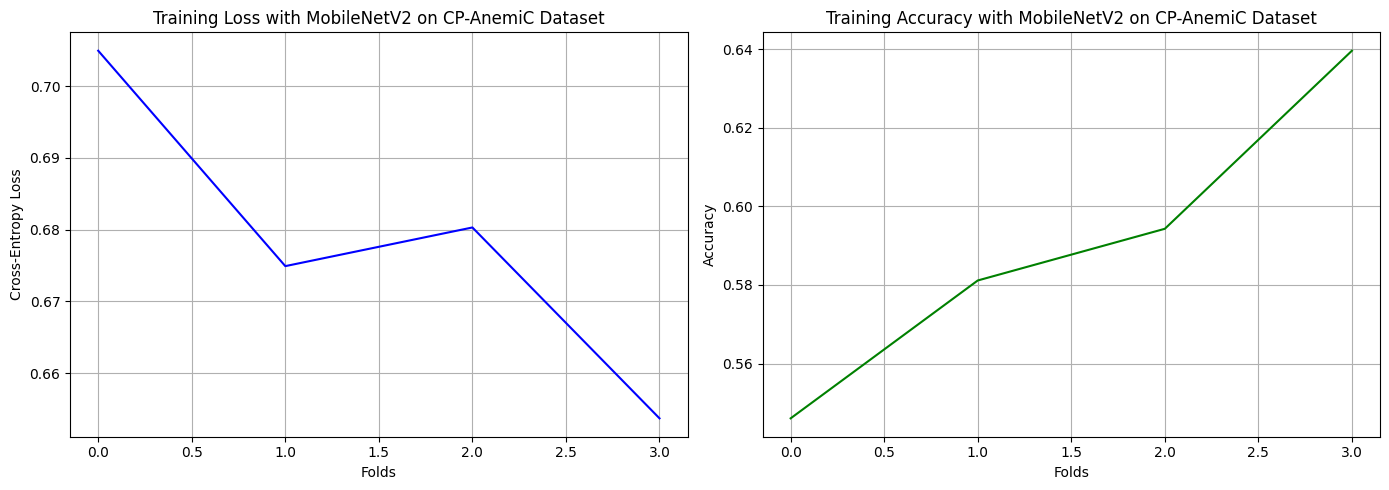

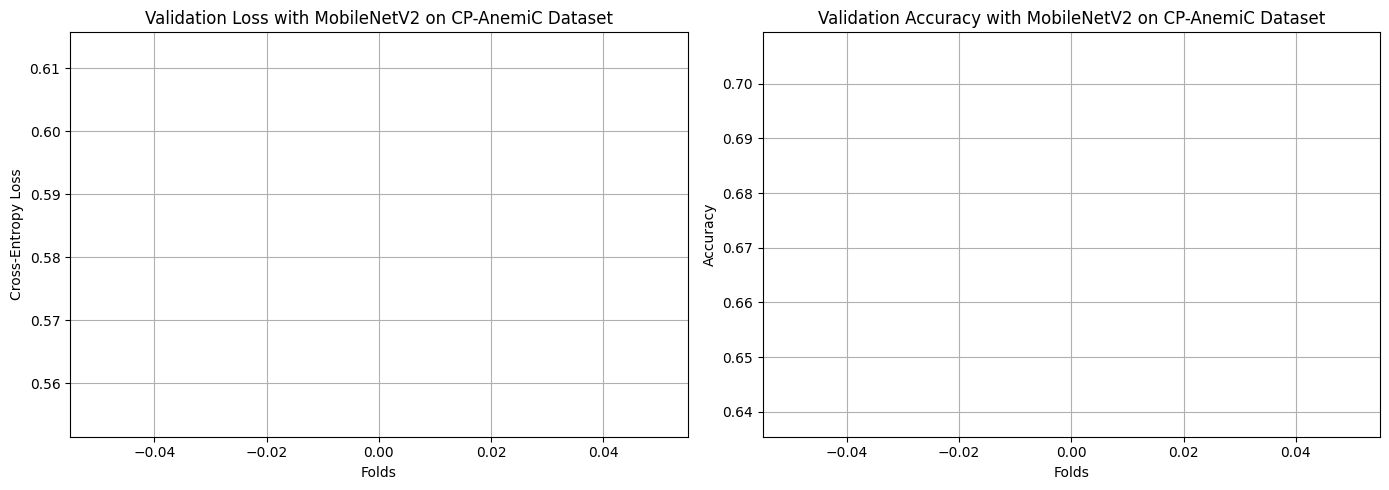

In [ ]:
model_name = f"MobileNetV2"#, {get_model_size(model)}"
plot_metrics(train_metrics_df, "Training", model_name)
plot_metrics(val_metrics_df, "Validation", model_name)

## Quantization Aware Training

Quantization-aware training (QAT) is the quantization method that typically results in the highest accuracy. *With QAT, all weights and activations are “fake quantized” during both the forward and backward passes of training: that is, float values are rounded to mimic int8 values, but all computations are still done with floating point numbers*. Thus, all the weight adjustments during training are made while “aware” of the fact that the model will ultimately be quantized; after quantizing, therefore, this method will usually yield higher accuracy than either dynamic quantization or post-training static quantization.

The overall workflow for actually performing QAT is very similar to before:

* We can use the same model as before: there is no additional preparation needed for quantization-aware training.
* We need to use a `qconfig` specifying what kind of fake-quantization is to be inserted after weights and activations, instead of specifying observers. In thi case we use `fbgemm` because of our operating system.

### PyTorch API:

* `torch.quantization.prepare_qat` inserts fake quantization modules to model quantization.
* Mimicking the static quantization API, `torch.quantization.convert` actually quantizes the model once training is complete.

### Overview of Quantizable MobileNetV2 Architecture

Different from the previous MobileNetV2 we saw, here instead of `2,225,153` parameters we only have `1,281` parameters. The quantizable model has several layers that have a quantized implementation of it (Conv2d, BN, ReLU, etc.) and quantizes and dequantizes the input at the beginning and end of the model.

In [ ]:
model_quantized = quant_models.mobilenet_v2(weights="MobileNet_V2_QuantizedWeights.IMAGENET1K_QNNPACK_V1", quantize=True)
model_quantized.classifier[1] = torch.nn.Linear(in_features=1280, out_features=1)
model_quantized = model_quantized.to(device)
print(summary(model_quantized))

Layer (type:depth-idx)                             Param #
QuantizableMobileNetV2                             --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─ConvReLU2d: 3-1                        --
│    │    └─Identity: 3-2                          --
│    │    └─Identity: 3-3                          --
│    └─QuantizableInvertedResidual: 2-2            --
│    │    └─Sequential: 3-4                        --
│    │    └─QFunctional: 3-5                       --
│    └─QuantizableInvertedResidual: 2-3            --
│    │    └─Sequential: 3-6                        --
│    │    └─QFunctional: 3-7                       --
│    └─QuantizableInvertedResidual: 2-4            --
│    │    └─Sequential: 3-8                        --
│    │    └─QFunctional: 3-9                       --
│    └─QuantizableInvertedResidual: 2-5            --
│    │    └─Sequential: 3-10                       --
│    │    └─QFunctional

We're not going to use directly the pretrained quantized model. Instead, we will perform Quantize-Aware Training on the model architecture that has been adapted to deal with quantization as have its weights adjusted for our anemia detection task.

In [ ]:
device = torch.device("cpu")
print(f"Selected device: {device}")

Selected device: cpu


In [ ]:
%%time

# Training parameters
BATCH_SIZE = 32
EPOCHS = 150
FOLDS = 5

# 5-fold cross-validation setup
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Initialize model, loss function, and optimizer
model_quantized = load_quantizable_mobilenet()
loss_fn = torch.nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for multi-label classification
optimizer = torch.optim.Adam(model_quantized.parameters(), lr=1e-4)  # Adam optimizer with learning rate

# Path where the model with the best precision is saved
weights_path = "/home/sebastian-cruz6/workspace/model-compression/models/weights"
os.makedirs(weights_path, exist_ok=True)  # Ensure the directory exists

best_val_f1score = -float('inf')  # Initialize with a very low value

train_metrics_df = []
val_metrics_df = []


for epochs in range(EPOCHS):
    print(f"\nEpoch {epochs+1}/{EPOCHS}")
    fold = 1
    fold_best_train_f1score = -float('inf')

    for train_idx, val_idx in kf.split(train_dataset):
        # Create subset datasets for training and validation
        train_subset = Subset(image_dataset, train_idx)
        val_subset = Subset(image_dataset, val_idx)

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

        if fold == FOLDS:
            # Validation loop
            avg_val_loss, val_metrics = eval(val_loader, model_quantized, loss_fn, mode="Validation", cumulative_metrics=cumulative_metrics)
            avg_val_accuracy, avg_val_precision, avg_val_recall, avg_val_f1, avg_val_auc = val_metrics.values()

            print(f"\nValidation: \tFold {fold} - Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}, Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, F1 Score: {avg_val_f1:.4f}, AUC Score: {avg_val_auc:.4f}")

            # Save the best model based on validation precision
            if avg_val_f1 > best_val_f1score:
                best_val_f1score = avg_val_f1

                val_metrics_dict = {**{"Loss":avg_val_loss}, **val_metrics}
                val_metrics_df.append(val_metrics_dict)

                torch.save(model_quantized.state_dict(), f'{weights_path}/quant_model_best_f1score.pth')
                print(f"Model with best precision during Validation saved at epoch {epochs + 1} with F1 Score of {best_val_f1score:.4f}")
        # """
        # Implement early stopping here as an elif statement
        # """
        else:
            # Training loop
            avg_train_loss, train_metrics = train(train_loader, model_quantized, loss_fn, optimizer, cumulative_metrics)
            avg_train_accuracy, avg_train_precision, avg_train_recall, avg_train_f1, avg_train_auc = train_metrics.values()

            if avg_train_f1 > fold_best_train_f1score:
                fold_best_train_f1score = avg_train_f1

                print(f"Training: \tFold {fold} - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}, Precision: {avg_train_precision:.4f}, Recall: {avg_train_recall:.4f}, F1 Score: {avg_train_f1:.4f}, AUC Score: {avg_train_auc:.4f}")
                train_metrics_dict = {**{"Loss":avg_train_loss}, **train_metrics}
                train_metrics_df.append(train_metrics_dict)

        # Reset metrics and model (if needed) for next fold
        cumulative_metrics.reset()

        fold += 1

model_quantized_and_trained = torch.quantization.convert(model_quantized.eval(), inplace=False)
print(get_model_size(model_quantized_and_trained))

Model Size: 14.24 MB

Epoch 1/150
Training: 	Fold 1 - Loss: 0.6867, Accuracy: 0.5597, Precision: 0.5597, Recall: 1.0000, F1 Score: 0.7133, AUC Score: 0.5667
Training: 	Fold 2 - Loss: 0.6776, Accuracy: 0.5889, Precision: 0.5889, Recall: 1.0000, F1 Score: 0.7363, AUC Score: 0.5440
Training: 	Fold 4 - Loss: 0.6597, Accuracy: 0.6018, Precision: 0.6018, Recall: 1.0000, F1 Score: 0.7497, AUC Score: 0.6159

Validation: 	Fold 5 - Loss: 0.6773, Accuracy: 0.5905, Precision: 0.5905, Recall: 1.0000, F1 Score: 0.7350, AUC Score: 0.5450
Model with best precision during Validation saved at epoch 1 with F1 Score of 0.7350

Epoch 2/150
Training: 	Fold 1 - Loss: 0.6706, Accuracy: 0.5868, Precision: 0.5868, Recall: 1.0000, F1 Score: 0.7341, AUC Score: 0.6087
Training: 	Fold 2 - Loss: 0.6468, Accuracy: 0.6069, Precision: 0.6069, Recall: 1.0000, F1 Score: 0.7526, AUC Score: 0.6627
Training: 	Fold 3 - Loss: 0.6366, Accuracy: 0.6222, Precision: 0.6222, Recall: 1.0000, F1 Score: 0.7640, AUC Score: 0.6680

Val

In [ ]:
train_metrics_df = pd.DataFrame(train_metrics_df)
display(train_metrics_df.sort_values(by='Accuracy', ascending=False)[:25])

,Loss,Accuracy,Precision,Recall,F1 Score,AUC
412,0.473863,0.864583,0.821888,0.996667,0.897331,0.996930
414,0.466977,0.847917,0.803497,0.996296,0.886463,0.996857
404,0.477771,0.843750,0.799023,1.000000,0.880649,0.993076
402,0.473577,0.843750,0.798038,1.000000,0.883102,0.990004
411,0.482000,0.843056,0.797179,0.992570,0.880145,0.991241
421,0.475415,0.843056,0.797724,1.000000,0.883711,0.994850
409,0.472334,0.842560,0.793622,0.996825,0.880820,0.996531
364,0.472701,0.840972,0.794770,1.000000,0.880576,0.992944
387,0.480149,0.840476,0.795165,0.996825,0.881336,0.994545
406,0.471624,0.839583,0.796036,0.997101,0.879624,0.995083


In [ ]:
val_metrics_df = pd.DataFrame(val_metrics_df)
display(val_metrics_df.sort_values(by='Accuracy', ascending=False)[:25])

,Loss,Accuracy,Precision,Recall,F1 Score,AUC
13,0.477965,0.954044,0.926603,1.000000,0.961273,0.999840
12,0.489820,0.937500,0.905976,0.986111,0.942998,0.990385
11,0.490331,0.922794,0.877347,1.000000,0.934038,0.999038
10,0.570896,0.915901,0.919872,0.926816,0.922693,0.961699
9,0.489298,0.899357,0.855083,0.988636,0.913300,0.989583
8,0.483899,0.868107,0.813149,1.000000,0.895442,0.991827
7,0.521962,0.855239,0.850595,0.958333,0.893701,0.947756
6,0.523060,0.852482,0.811601,0.972222,0.882879,0.960577
5,0.503623,0.805607,0.751493,1.000000,0.850874,0.972276
4,0.546216,0.758732,0.717568,0.986111,0.820174,0.903526


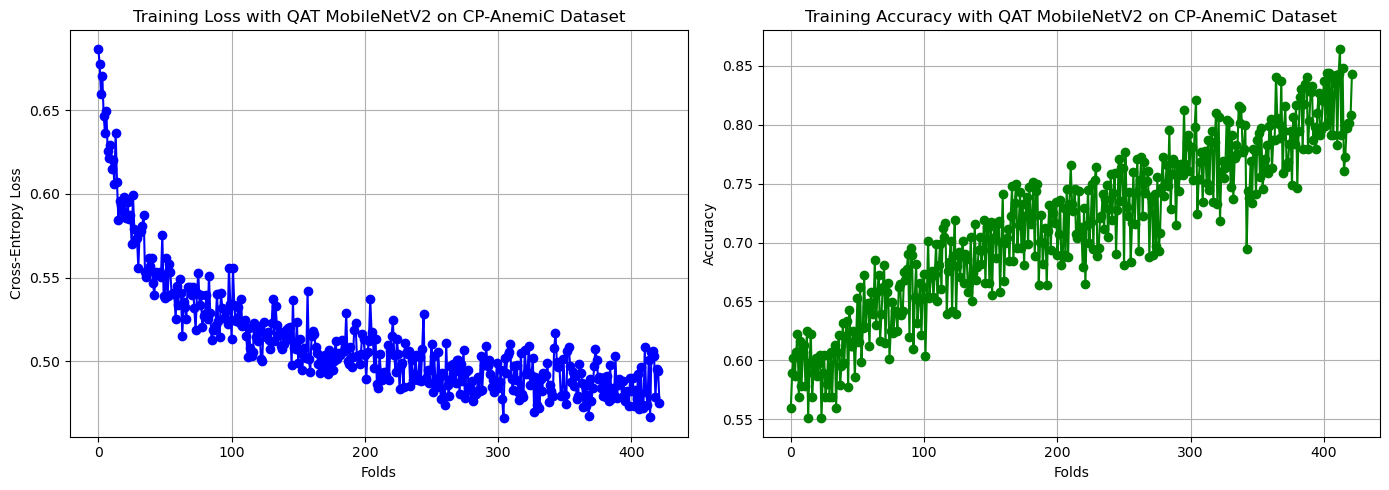

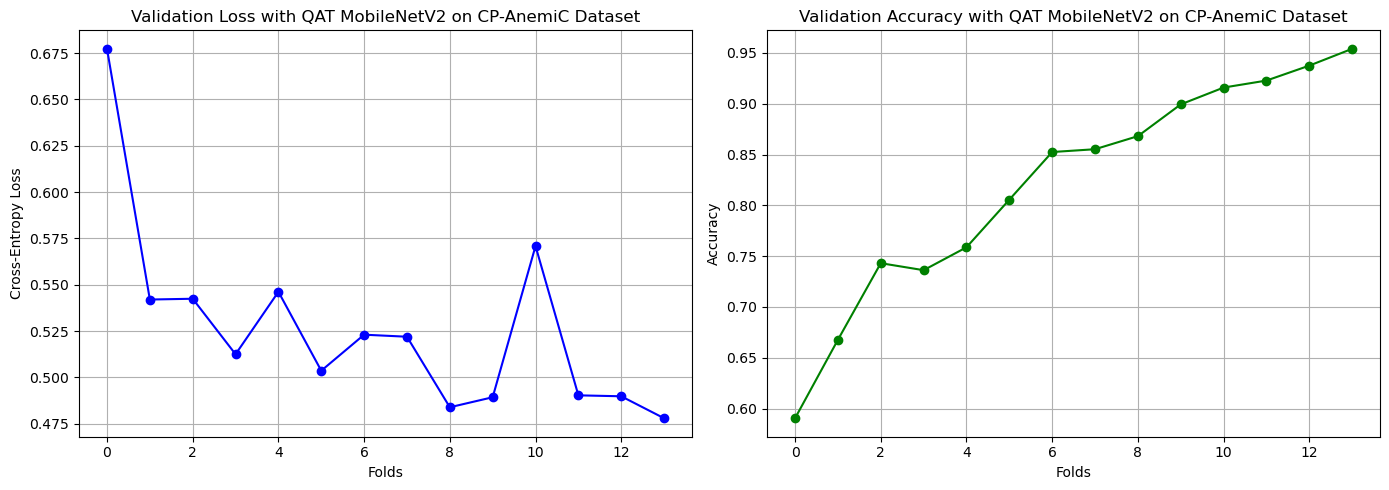

In [ ]:
model_name = f"QAT MobileNetV2"#, {get_model_size(model_quantized_and_trained)}"
plot_metrics(train_metrics_df, "Training", model_name)
plot_metrics(val_metrics_df, "Validation", model_name)

## Testing

We can test our models performance by loading a single batch a visualizing those predictions

In [ ]:
# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("CUDA is not available, using CPU.")
print(f"Selected device: {device}")

Selected device: cuda


In [ ]:
%%time

test_loss, test_performance_metrics = eval(test_loader, model, loss_fn, 'Testing', CumulativeMetrics())
test_accuracy, test_precision, test_recall, test_f1, test_auc = test_performance_metrics.values()
print(f"Testing: \tLoss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, AUC Score: {test_auc:.4f}")


Testing: 	Loss: 0.4641, Accuracy: 0.8964, Precision: 0.8769, Recall: 0.9800, F1 Score: 0.9247, AUC Score: 0.9905
CPU times: user 960 ms, sys: 82.9 ms, total: 1.04 s
Wall time: 65.5 ms


In [ ]:
device = torch.device("cpu")
print(f"Selected device: {device}")

Selected device: cpu


In [ ]:
%%time

test_loss, test_performance_metrics = eval(test_loader, model_quantized_and_trained, loss_fn, 'Testing', CumulativeMetrics())
test_accuracy, test_precision, test_recall, test_f1, test_auc = test_performance_metrics.values()
print(f"Testing: \tLoss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, AUC Score: {test_auc:.4f}")

Testing: 	Loss: 0.4749, Accuracy: 0.8920, Precision: 0.8654, Recall: 0.9905, F1 Score: 0.9230, AUC Score: 0.9699
CPU times: user 54.3 s, sys: 1.04 s, total: 55.4 s
Wall time: 1.19 s
